<a href="https://colab.research.google.com/github/ShrishtiSingh26/CNN-models-on-Education-Dataset/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Required imports
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
#import matplotlib.pyplot as plt
file_path = '/content/StudentPerformanceFactors.csv'
data = pd.read_csv(file_path)

In [31]:
# Handling missing values by filling with the mode (for categorical) and mean (for numerical if applicable)
data['Teacher_Quality'] = data['Teacher_Quality'].fillna(data['Teacher_Quality'].mode()[0])
data['Parental_Education_Level'] = data['Parental_Education_Level'].fillna(data['Parental_Education_Level'].mode()[0])
data['Distance_from_Home'] = data['Distance_from_Home'].fillna(data['Distance_from_Home'].mode()[0])

# Normalizing the target variable 'Exam_Score' (converting to float to prevent scaling issues later)
data['Exam_Score'] = data['Exam_Score'].astype(float)

# Apply MinMaxScaler to 'Exam_Score' to scale between 0 and 1 for better performance in the neural network
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['Exam_Score'] = scaler.fit_transform(data[['Exam_Score']])

# Data is now ready for the rest of the pipeline.
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Hours_Studied               6607 non-null   int64  
 1   Attendance                  6607 non-null   int64  
 2   Parental_Involvement        6607 non-null   object 
 3   Access_to_Resources         6607 non-null   object 
 4   Extracurricular_Activities  6607 non-null   object 
 5   Sleep_Hours                 6607 non-null   int64  
 6   Previous_Scores             6607 non-null   int64  
 7   Motivation_Level            6607 non-null   object 
 8   Internet_Access             6607 non-null   object 
 9   Tutoring_Sessions           6607 non-null   int64  
 10  Family_Income               6607 non-null   object 
 11  Teacher_Quality             6607 non-null   object 
 12  School_Type                 6607 non-null   object 
 13  Peer_Influence              6607 

(None,
    Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
 0             23          84                  Low                High   
 1             19          64                  Low              Medium   
 2             24          98               Medium              Medium   
 3             29          89                  Low              Medium   
 4             19          92               Medium              Medium   
 
   Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
 0                         No            7               73              Low   
 1                         No            8               59              Low   
 2                        Yes            7               91           Medium   
 3                        Yes            8               98           Medium   
 4                        Yes            6               65           Medium   
 
   Internet_Access  Tutoring_Sessions Family_Income Teacher_Quali

In [32]:
# Data Preprocessing
# Drop the target column from X and store target in y
X = data.drop('Exam_Score', axis=1)  # Replace 'Exam_Score' with the actual target column if different
y = data['Exam_Score'].values

In [33]:
# Encoding categorical columns (non-numerical columns) using OneHotEncoder
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns


In [34]:
# Build a preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

In [35]:
# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

In [36]:
# Ensure that the data is in the correct format (convert to float32)
X_processed = np.array(X_processed, dtype='float32')

In [37]:
# One-hot encode the target labels (assuming multi-class classification)
y = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))

In [38]:
# Reshape the data for CNN input
X_processed = X_processed.reshape(X_processed.shape[0], X_processed.shape[1], 1)

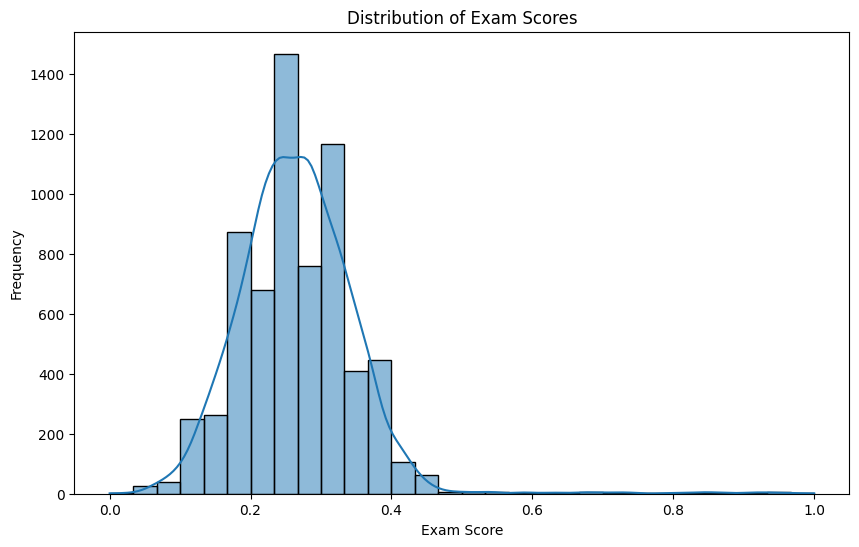

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['Exam_Score'], kde=True, bins=30)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.show()


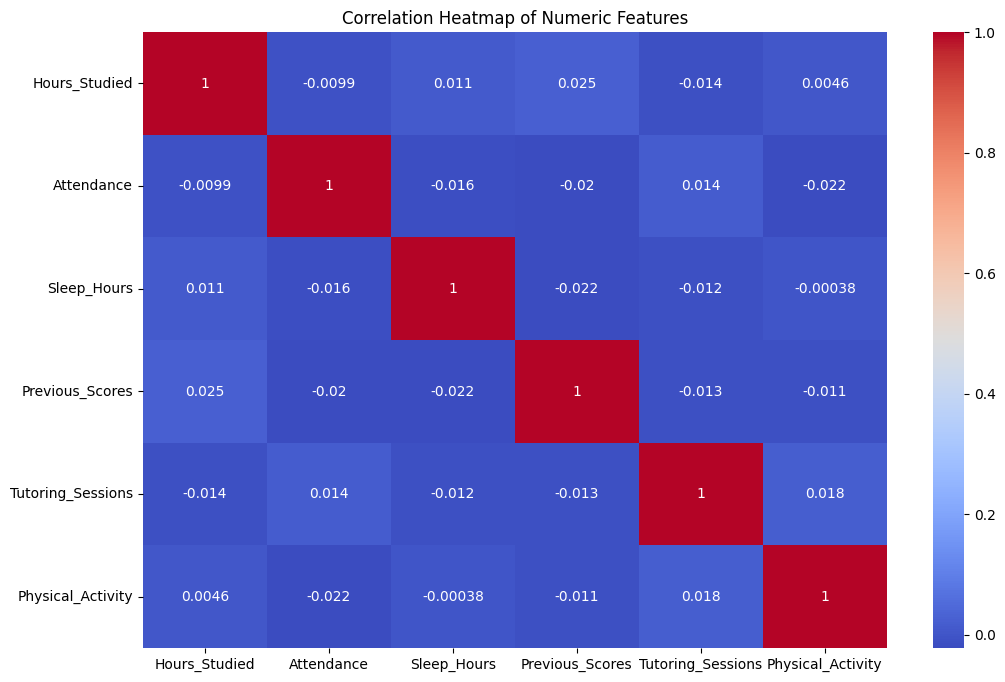

In [40]:
# Plot correlation heatmap for numeric columns
plt.figure(figsize=(12, 8))
numeric_data = data[numeric_columns]
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


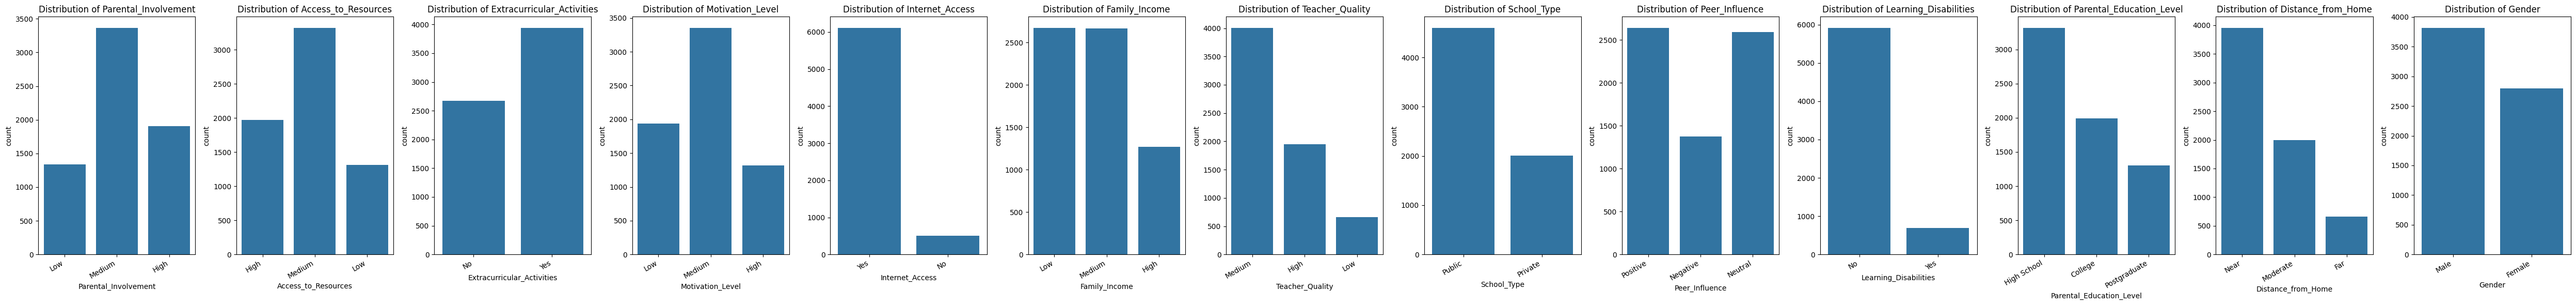

In [41]:
# Visualize the distribution of categorical columns
plt.figure(figsize=(50, 6))  # Increased width for better spacing
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(1, len(categorical_columns), i)
    sns.countplot(x=column, data=data)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=30, ha='right')  # Rotate labels and align to right

plt.tight_layout()  # This can also be fig.tight_layout()
plt.show()


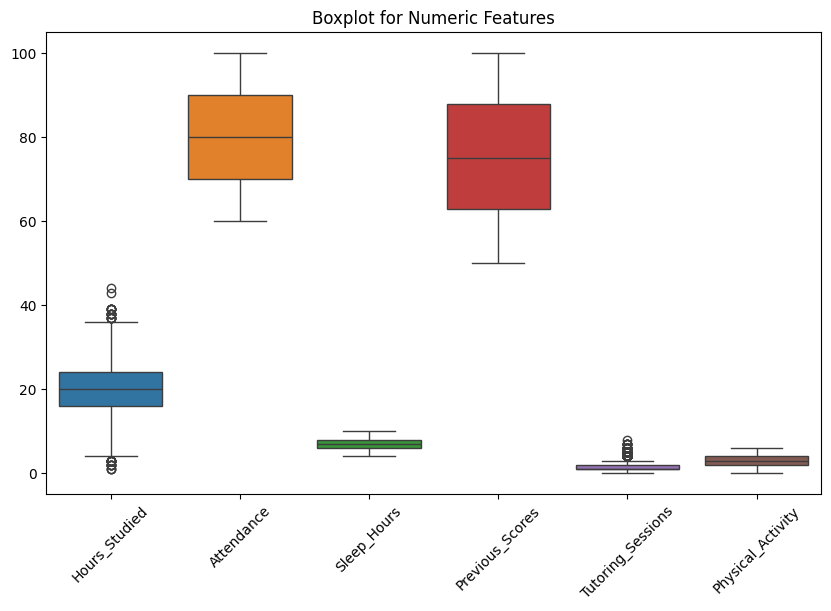

In [42]:
# Visualize potential outliers using boxplots for numeric columns
plt.figure(figsize=(10, 6))
sns.boxplot(data=numeric_data)
plt.title('Boxplot for Numeric Features')
plt.xticks(rotation=45)
plt.show()


In [43]:
#  Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=40)

In [44]:
# Model Definition using Input() layer
def create_model_1():
    input_layer = layers.Input(shape=(X_train.shape[1], 1))
    # First Conv1D Block
    conv1 = layers.Conv1D(128, kernel_size=7, activation='relu')(input_layer)
    batch_norm1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(batch_norm1)

    # Second Conv1D Block
    conv2 = layers.Conv1D(256, kernel_size=5, activation='relu')(pool1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(batch_norm2)

    # Third Conv1D Block
    conv3 = layers.Conv1D(512, kernel_size=3, activation='relu')(pool2)
    batch_norm3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(batch_norm3)



    # Flatten and Dense Layer
    flat = layers.Flatten()(pool3)
    dense1 = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(flat)
    dropout1 = layers.Dropout(0.4)(dense1)

    # Output Layer for multi-class classification
    output_layer = layers.Dense(y_train.shape[1], activation='softmax')(dropout1)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [45]:
# Define the second model similarly
def create_model_2():
    input_layer = layers.Input(shape=(X_train.shape[1], 1))
    conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')(input_layer)
    batch_norm1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(batch_norm1)
    conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')(pool1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(batch_norm2)
    conv3 = layers.Conv1D(256, kernel_size=3, activation='relu')(pool2)
    batch_norm3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(batch_norm3)
    flat = layers.Flatten()(pool3)
    dense1 = layers.Dense(521, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(flat)
    dropout1 = layers.Dropout(0.5)(dense1)
    output_layer = layers.Dense(y_train.shape[1], activation='softmax')(dropout1)  # For multi-class classification
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [46]:
#  Train and Evaluate Models
def train_and_evaluate_model(model):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Learning Rate Scheduling
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Model Compilation and Training
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping, lr_scheduler])
  # Evaluate the model on the test set
  y_pred = model.predict(X_test)
      # Convert predicted probabilities to class labels
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_test_classes = np.argmax(y_test, axis=1)
  # Calculate accuracy, precision, and F1 score
  accuracy = accuracy_score(y_test_classes, y_pred_classes)
  precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
  f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)

  return accuracy, precision, f1

In [47]:
# Train and evaluate both models
model_1 = create_model_1()
accuracy_1, precision_1, f1_1 = train_and_evaluate_model(model_1)

model_2 = create_model_2()
accuracy_2, precision_2, f1_2 = train_and_evaluate_model(model_2)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.1270 - loss: 11.6113 - val_accuracy: 0.1134 - val_loss: 6.9025 - learning_rate: 0.0010
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.2960 - loss: 4.4739 - val_accuracy: 0.1550 - val_loss: 4.1885 - learning_rate: 0.0010
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.3348 - loss: 2.6446 - val_accuracy: 0.2382 - val_loss: 2.8190 - learning_rate: 0.0010
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.3989 - loss: 2.0206 - val_accuracy: 0.3913 - val_loss: 1.8724 - learning_rate: 0.0010
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.4276 - loss: 1.8342 - val_accuracy: 0.4216 - val_loss: 1.6750 - learning_rate: 0.0010
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.4664 - loss: 1.6450 - val_accuracy: 0.4008 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.4975 -

In [48]:
# Print the results for both models
print(f"Model 1 - Accuracy: {accuracy_1},\n Precision: {precision_1},\n F1 Score: {f1_1}\n")
print(f"Model 2 - Accuracy: {accuracy_2},\n Precision: {precision_2},\n F1 Score: {f1_2}")

Model 1 - Accuracy: 0.5801815431164902,
 Precision: 0.60031175905855,
 F1 Score: 0.5750229815479448

Model 2 - Accuracy: 0.602874432677761,
 Precision: 0.6123596842521148,
 F1 Score: 0.5963578542349454
